In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
from tflearn.data_utils import shuffle, to_categorical
import numpy as np

In [2]:
# Load kaggle train data
train = pd.read_csv('./input/train.csv')
train.shape

(42000, 785)

In [14]:
type(train)

pandas.core.frame.DataFrame

In [3]:
# extract X, y kaggle train data
X, Y = train.drop('label', axis=1).values, train['label'].values

print X.shape
print Y.shape

(42000, 784)
(42000,)


In [15]:
type(X)

numpy.ndarray

In [4]:
X, X_test, Y, Y_test = train_test_split(
    X,
    Y,
    test_size=0.15,
    random_state=42,
    stratify=train[train.columns[0]].values, # to preserve initial class balance
)

print "X shape:", X.shape
print "X_test shape:", X_test.shape
print "Y shape:", Y.shape
print "Y_test shape:", Y_test.shape

X shape: (35700, 784)
X_test shape: (6300, 784)
Y shape: (35700,)
Y_test shape: (6300,)


In [5]:
X = X.reshape([-1, 28, 28, 1])
X_test = X_test.reshape([-1, 28, 28, 1])
Y = to_categorical(Y, 10)
Y_test = to_categorical(Y_test, 10)

print "X shape:", X.shape
print "X_test shape:", X_test.shape
print "Y shape:", Y.shape
print "Y_test shape:", Y_test.shape

X shape: (35700, 28, 28, 1)
X_test shape: (6300, 28, 28, 1)
Y shape: (35700, 10)
Y_test shape: (6300, 10)


## Train

In [6]:
OPTIMIZER = 'Adam'
LEARNING_RATE = 0.0001
N_EPOCH = 10

RUN_ID = 'Train Adam, 0.0001, n10'

network = input_data(shape=[None, 28, 28, 1], name='input')

network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)

network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)

network = fully_connected(network, 128, activation='tanh')
network = dropout(network, 0.8)

network = fully_connected(network, 256, activation='tanh')
network = dropout(network, 0.8)

network = fully_connected(network, 10, activation='softmax')

network = regression(
    network, 
    optimizer=OPTIMIZER, 
    learning_rate=LEARNING_RATE, 
    loss='categorical_crossentropy', 
    name='target'
)

model = tflearn.DNN(network, tensorboard_verbose=3)
model.fit(
    {'input': X}, {'target': Y},
    n_epoch=N_EPOCH,
    validation_set=({'input': X_test}, {'target': Y_test}),
    snapshot_step=100, 
    show_metric=True,
    run_id=RUN_ID
)

Training Step: 5579  | total loss: 0.01445 | time: 26.399s
| Adam | epoch: 010 | loss: 0.01445 - acc: 0.9969 -- iter: 35648/35700
Training Step: 5580  | total loss: 0.01445 | time: 27.497s
| Adam | epoch: 010 | loss: 0.01445 - acc: 0.9969 | val_loss: 0.05126 - val_acc: 0.9848 -- iter: 35700/35700
--


## Predict

In [65]:
X_submission = pd.read_csv('./input/test.csv').values

print X_submission.shape

(28000, 784)


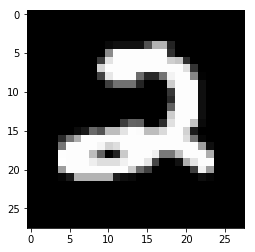

In [93]:
plt.imshow(X_submission[0].reshape(28, 28), cmap=plt.get_cmap('gray'))

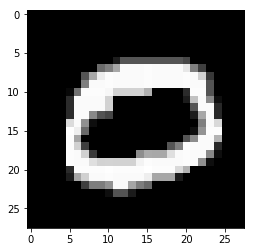

In [94]:
plt.imshow(X_submission[1].reshape(28, 28), cmap=plt.get_cmap('gray'))

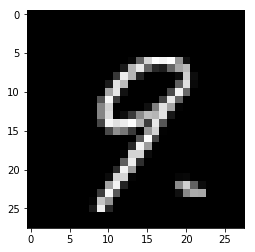

In [95]:
plt.imshow(X_submission[2].reshape(28, 28), cmap=plt.get_cmap('gray'))

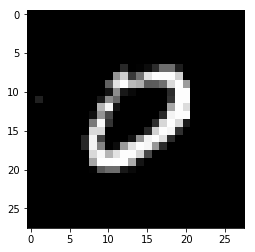

In [96]:
plt.imshow(X_submission[3].reshape(28, 28), cmap=plt.get_cmap('gray'))

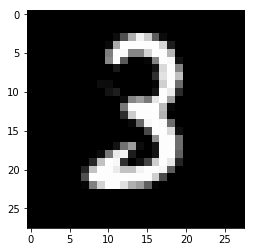

In [97]:
plt.imshow(X_submission[4].reshape(28, 28), cmap=plt.get_cmap('gray'))

In [67]:
X_submission = X_submission.reshape([-1, 28, 28, 1])

print X_submission.shape

(28000, 28, 28, 1)


In [98]:
Y_predict_label = model.predict_label(X_submission)
print Y_predict_label[0]
print Y_predict_label[1]
print Y_predict_label[2]
print Y_predict_label[3]
print Y_predict_label[4]

[5 9 6 7 4 1 0 3 8 2]
[6 2 1 5 0 8 3 7 4 9]
[4 6 0 8 1 9 2 7 5 3]
[6 8 5 1 4 2 3 0 9 7]
[6 1 2 0 5 7 3 8 4 9]


In [100]:
Y_predict = model.predict(X_submission)
Y_predict = np.argmax(Y_predict,axis=1)
print Y_predict[0]
print Y_predict[1]
print Y_predict[2]
print Y_predict[3]
print Y_predict[4]

2
0
9
9
3


In [102]:
submission=pd.DataFrame({"ImageId": list(range(1,len(Y_predict)+1)), "Label": Y_predict})
submission.to_csv("./submissions/submission_ccn_tflearn_lr_0_001_nepoch_10.csv", index=False, header=True)